# Dynamics of # of mutations over time

In [1]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(lazyeval))
suppressPackageStartupMessages(library(reshape2))

suppressPackageStartupMessages(source("../R/process_slim_output.R"))

In [2]:
traject_dir <- "../simulations/different_models"

## Numbers of deleterious mutations per haploid exome just before introgression

In [3]:
slim_file <- read_slim_file("../simulations/exome_and_sites__h_0.5__seed_6977220333793.txt")

nea_muts <- read_mutations(slim_file, "m0", "p2")         %>% mutate(freq=count / (2 * 1000), mutations="Nea")
mh_muts <- read_mutations(slim_file, "m0", "p1", t=50000) %>% mutate(freq=count / (2 * (10000 + 1861)), mutations="AMH")

before_admixture <- rbind(mh_muts, nea_muts)

Total number of mutations in the population:

In [4]:
nrow(nea_muts)
nrow(mh_muts)

[1] 12558

[1] 107666

Total number of fixed mutations:

In [5]:
nrow(filter(nea_muts, freq == 1.0))
nrow(filter(mh_muts, freq == 1.0))

[1] 2139

[1] 29

SFS of deleterious mutations accumulated on the AMH and Nea. lineages

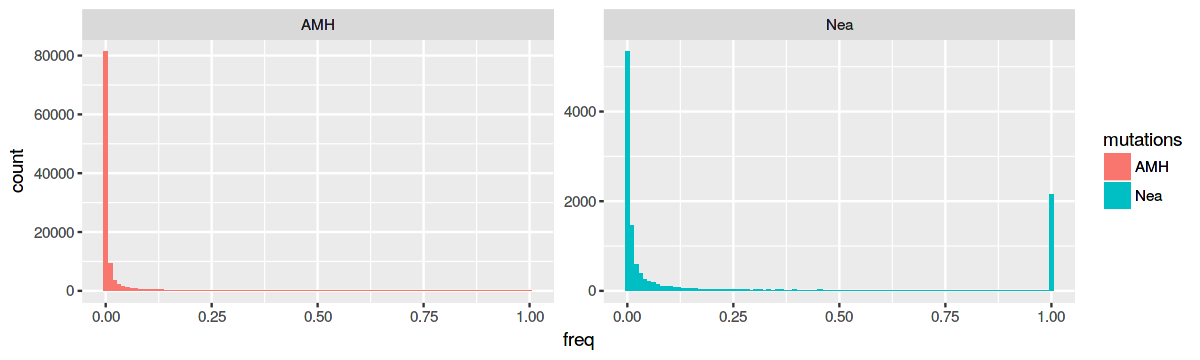

In [7]:
options(repr.plot.width=10, repr.plot.height=3)

ggplot(before_admixture, aes(freq, fill=mutations)) + geom_histogram(bins=100) + facet_wrap(~ mutations, scales="free")

In [26]:
# read Neanderthal genomes
nea_indivs  <- read_individuals(slim_file, "p2")
nea_genomes <- read_genomes(slim_file, "p2")

# read AMH genomes
mh_indivs   <- read_individuals(slim_file, "p3")
mh_genomes  <- read_genomes(slim_file, "p3")

# match each mutation in each individual genome against its
# SLiM description
nea_muts_per_genome <- left_join(nea_genomes, nea_muts, by="mut_id")
mh_muts_per_genome <- left_join(mh_genomes, mh_muts, by="mut_id")

In [27]:
nea_mut_count <- group_by(nea_muts_per_genome, genome_id) %>% summarise(count=sum(!is.na(mut_type)))
mh_mut_count <- group_by(mh_muts_per_genome, genome_id) %>% summarise(count=sum(!is.na(mut_type)))

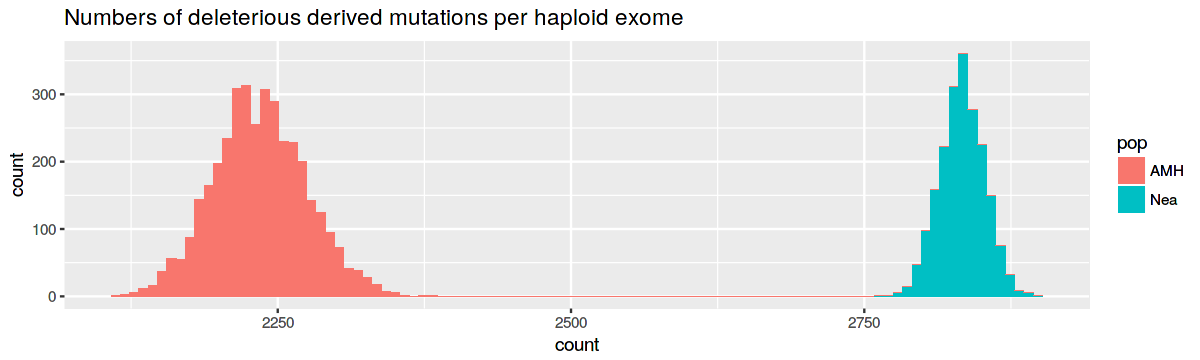

In [28]:
bind_rows(
    nea_mut_count %>% mutate(pop="Nea"),
    mh_mut_count %>% mutate(pop="AMH")
) %>%
ggplot(aes(count, fill=pop)) +
geom_histogram(bins=100) +
    ggtitle("Numbers of deleterious derived mutations per haploid exome")

Neanderthal exome carries on average 1000 more deleterious mutations than an anatomically modern human exome - consistent with Sergi's exome study.

## Numbers of deleterious mutations per haploid exome over time

In [35]:
library(parallel)

In [36]:
(gens <- c(1:30, seq(100, 2200, 300))) 
(models <- c("gravel", "constant"))
(dominances <- c("0.5"))

[1]    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15
[16]   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30
[31]  100  400  700 1000 1300 1600 1900 2200

[1] "gravel"   "constant"

[1] "0.5"

In [37]:
combinations <- expand.grid(gen=gens, model=models, h=dominances)

In [38]:
if (!file.exists("../tmp/deleterious_mutation_per_genome.Rds")) {

counts_list <-
    mclapply(
        1 : nrow(combinations),
        function(i) {
            model <- combinations[i, "model"]
            gen <- as.integer(combinations[i, "gen"])
            h <- combinations[i, "h"]

            # load the whole SLiM output file first
            slim_file <- read_slim_file(file.path(traject_dir,
                                                  paste0(model,
                                                         "__h_",
                                                         h,
                                                         "__init_nea_0.1__rep_1__dump_gen_",
                                                         gen,
                                                         ".txt")))

            # load Neanderthal- and MH-specific deleterious variants segregating
            # in the MH population
            nea_muts <- read_mutations(slim_file, "m0", "p2")
            mh_muts <- bind_rows(read_mutations(slim_file, "m0", "p1", t=50000),
                                 read_mutations(slim_file, "m0", "p3"))

            # load tables with IDs of all MH individuals and their genomes
            mh_indivs <- read_individuals(slim_file, "p3")
            mh_genomes <- read_genomes(slim_file, "p3")

            # match each mutation in each individual genome against its
            # selection coefficient and other data
            nea_muts_per_genome <- left_join(mh_genomes, nea_muts, by="mut_id")
            mh_muts_per_genome <- left_join(mh_genomes, mh_muts, by="mut_id")

            nea_mut_count <- group_by(nea_muts_per_genome, genome_id) %>% summarise(count=sum(!is.na(mut_type))) %>% mutate(mutation="Nea")
            mh_mut_count <- group_by(mh_muts_per_genome, genome_id) %>% summarise(count=sum(!is.na(mut_type))) %>% mutate(mutation="AMH")

            bind_rows(nea_mut_count, mh_mut_count) %>% mutate(gen=gen, model=model, h=h)
            
        },
        mc.cores=40
    )

counts <- bind_rows(counts_list) %>% mutate(gen=factor(gen))
saveRDS(counts, "../tmp/deleterious_mutation_per_genome.Rds")

} else {
    
counts <- readRDS("../tmp/deleterious_mutation_per_genome.Rds")

}

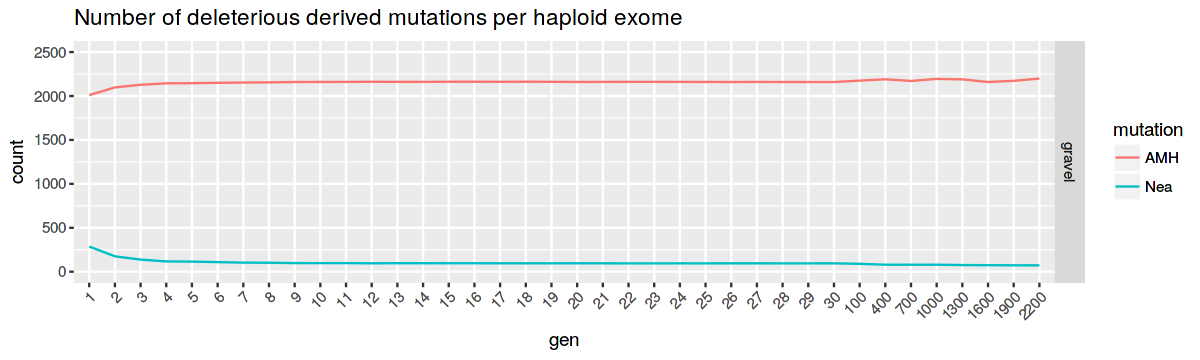

In [52]:
options(repr.plot.width=10, repr.plot.height=3)

counts %>% filter(model == "gravel") %>% 
group_by(gen, mutation, model) %>% 
summarise(count=mean(count)) %>%
ggplot(aes(gen, count, color=mutation, group=mutation)) +
    geom_line() +
    ylim(0, 2500) +
    facet_grid(model ~ .) +
    ggtitle("Number of deleterious derived mutations per haploid exome") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

Mean number of deleterious mutations in each generation:

In [46]:
group_by(filter(counts, model == "gravel"), mutation, gen) %>% summarise(mean=mean(count)) %>% spread(mutation, mean)

gen,AMH,Nea
1,2009.941,286.29581
2,2097.953,175.16846
3,2127.912,137.93471
4,2144.164,117.43740
5,2146.239,114.92638
6,2149.896,109.47797
7,2153.194,103.55051
8,2155.177,102.07818
9,2159.351,98.29957
10,2160.147,98.16577


## Numbers of deleterious mutations in the whole population

In [61]:
library(parallel)

In [62]:
(gens <- c(1:30, seq(100, 2200, 300))) 
(models <- c("gravel"))
(dominances <- c("0.5"))

[1]    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15
[16]   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30
[31]  100  400  700 1000 1300 1600 1900 2200

[1] "gravel"

[1] "0.5"

In [63]:
combinations <- expand.grid(gen=gens, model=models, h=dominances)

In [64]:
counts_list <-
    mclapply(
        1 : nrow(combinations),
        function(i) {
            model <- combinations[i, "model"]
            gen <- as.integer(combinations[i, "gen"])
            h <- combinations[i, "h"]

            # load the whole SLiM output file first
            slim_file <- read_slim_file(file.path(traject_dir,
                                                  paste0(model,
                                                         "__h_",
                                                         h,
                                                         "__init_nea_0.1__rep_1__dump_gen_",
                                                         gen,
                                                         ".txt")))

            # load Neanderthal- and MH-specific deleterious variants segregating
            # in the MH population
            nea_muts <- read_mutations(slim_file, "m0", "p2")
            mh_muts <- bind_rows(read_mutations(slim_file, "m0", "p1", t=50000),
                                 read_mutations(slim_file, "m0", "p3"))

            list(gen=gen,
                 model=model,
                 nea_count=nrow(nea_muts),
                 mh_count=nrow(mh_muts))
            
        },
        mc.cores=40
    )

In [66]:
bind_rows(lapply(counts_list, data.frame)) %>% head
bind_rows(lapply(counts_list, data.frame)) %>% tail

gen,model,nea_count,mh_count
1,gravel,9358,63741
2,gravel,8001,61313
3,gravel,7331,59083
4,gravel,6831,57498
5,gravel,6468,56204
6,gravel,6199,55132


,gen,model,nea_count,mh_count
33,700,gravel,780,25907
34,1000,gravel,558,24741
35,1300,gravel,411,18681
36,1600,gravel,341,34661
37,1900,gravel,320,92860
38,2200,gravel,313,275521


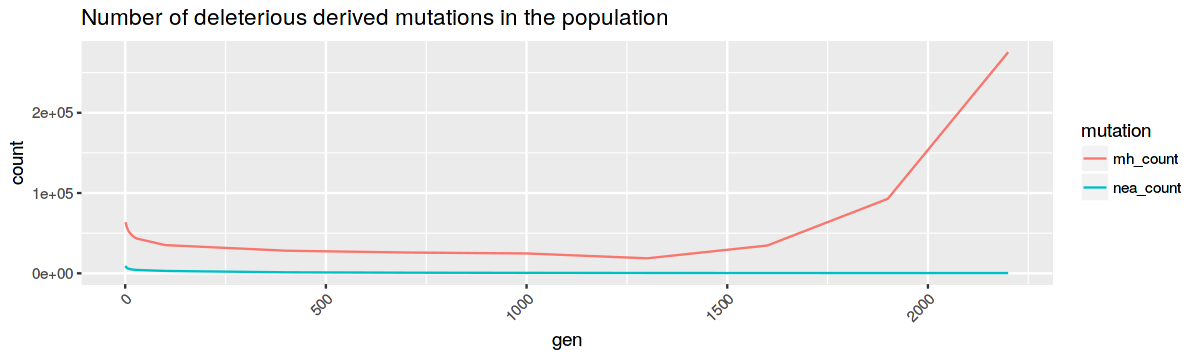

In [30]:
options(repr.plot.width=10, repr.plot.height=3)

bind_rows(lapply(counts_list, data.frame)) %>% gather(mutation, count, -gen) %>%
ggplot(aes(gen, count, color=mutation)) +
    geom_line() +
    ggtitle("Number of deleterious derived mutations in the population") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

### A test of the code on the neutral Nea. mutations

This should give the same results as the Nea. trajectory analysis of mean Nea. average ancestries.

In [40]:
library(parallel)

In [41]:
(gens <- c(1:30, seq(100, 2200, 300))) 
(models <- c("gravel"))
(dominances <- c("0.5"))

[1]    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15
[16]   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30
[31]  100  400  700 1000 1300 1600 1900 2200

[1] "gravel"

[1] "0.5"

In [42]:
combinations <- expand.grid(gen=gens, model=models, h=dominances)

In [53]:
if (!file.exists("../tmp/neutral_mutation_counts.Rds")) {

counts_list <-
    mclapply(
        1 : nrow(combinations),
        function(i) {
            model <- combinations[i, "model"]
            gen <- as.integer(combinations[i, "gen"])
            h <- combinations[i, "h"]

            # load the whole SLiM output file first
            slim_file <- read_slim_file(file.path(traject_dir,
                                                  paste0(model,
                                                         "__h_",
                                                         h,
                                                         "__init_nea_0.1__rep_1__dump_gen_",
                                                         gen,
                                                         ".txt")))

            # load Neanderthal- and MH-specific deleterious variants segregating
            # in the MH population
            nea_muts <- read_mutations(slim_file, "m2", "p2")

            # load tables with IDs of all MH individuals and their genomes
            mh_indivs <- read_individuals(slim_file, "p3")
            mh_genomes <- read_genomes(slim_file, "p3")

            # match each mutation in each individual genome against its
            # selection coefficient and other data
            nea_muts_per_genome <- left_join(mh_genomes, nea_muts, by="mut_id")

            nea_mut_count <- group_by(nea_muts_per_genome, genome_id) %>% summarise(count=sum(!is.na(mut_type))) %>% mutate(mutation="Nea")

            nea_mut_count %>% mutate(gen=gen, model=model, h=h)
            
        },
        mc.cores=40
    )

counts <- bind_rows(counts_list) %>% mutate(gen=factor(gen))
saveRDS(counts, "../tmp/neutral_mutation_counts.Rds")

} else {
    
counts <- readRDS("../tmp/neutral_mutation_counts.Rds")

}

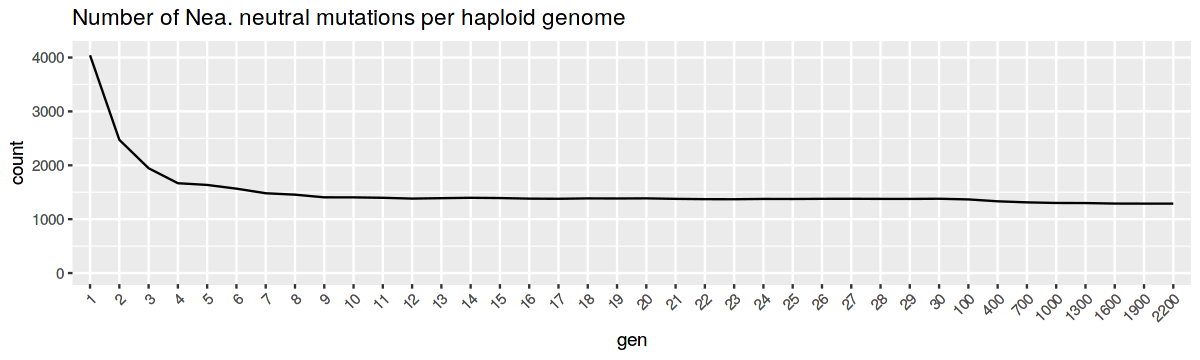

In [57]:
options(repr.plot.width=10, repr.plot.height=3)

counts %>%
group_by(gen) %>% 
summarise(count=mean(count)) %>%
ggplot(aes(gen, count, group=1)) +
    geom_line() +
    ylim(0, 4100) +
    ggtitle("Number of Nea. neutral mutations per haploid genome") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

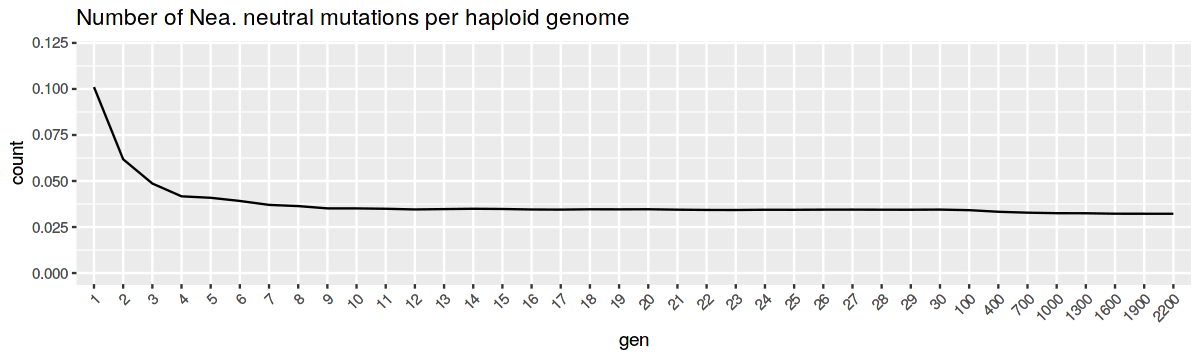

In [59]:
options(repr.plot.width=10, repr.plot.height=3)

counts %>%
group_by(gen) %>% 
summarise(count=mean(count / 40000)) %>%
ggplot(aes(gen, count, group=1)) +
    geom_line() +
    ylim(0, 0.12) +
    ggtitle("Number of Nea. neutral mutations per haploid genome") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))